## EDA

In [1]:
import random, numpy as np, pandas as pd, torch
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from wordcloud import WordCloud

In [2]:
def fix_seed(seed: int = 42) -> None:
    """
    Fix random seeds for reproducibility across libraries.

    Parameters
    ----------
    seed : int, optional, default=42
        The random seed value to be set for Python's `random`, NumPy, and PyTorch.

    Returns
    -------
    None
        Sets the seed in place; no value is returned.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


fix_seed(42)

raw_df = pd.read_csv('fake_news_full_data.csv', index_col=0)
raw_df


,title,text,date,is_fake
0,Earthquake hits off Papua New Guinea,LONDON (Reuters) - A magnitude 5.9 earthquake ...,"September 17, 2017",0
1,CINDY MCCAIN Reportedly Accepts Trump Administ...,The Hill released controversial comments sore ...,"Jun 12, 2017",1
2,Prosecutors say ex-House Speaker Hastert sexua...,(Reuters) - Former U.S. House Speaker Dennis H...,"April 9, 2016",0
3,Romanian protesters halt building of Xmas fair...,BUCHAREST (Reuters) - Romanian protesters clas...,"December 2, 2017",0
4,"Congo elected to U.N. rights council; Britain,...",UNITED NATIONS (Reuters) - Democratic Republic...,"October 16, 2017",0
...,...,...,...,...
44675,"In new blow to campaign, Trump's foundation or...",WASHINGTON (Reuters) - New York’s attorney gen...,"October 3, 2016",0
44676,MICHELLE OBAMA’S Middle East Speech: Compares ...,Michelle Obama received $70 million dollars fr...,"Nov 6, 2015",1
44677,LEFTY COMMUNIST Calls Trump-Supporting High Sc...,"If you haven t discovered Austen Fletcher yet,...","Nov 3, 2017",1
44678,SWISS ARMY CHIEF WARNS CITIZENS About Explosiv...,Wouldn t it be great if we had someone in gove...,"Dec 31, 2015",1


In [3]:
print("shape:", raw_df.shape)
print("columns:", raw_df.columns.tolist())

shape: (44680, 4)
columns: ['title', 'text', 'date', 'is_fake']


In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44680 entries, 0 to 44679
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44680 non-null  object
 1   text     44680 non-null  object
 2   date     44680 non-null  object
 3   is_fake  44680 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.7+ MB


In [5]:
d = pd.to_datetime(raw_df["date"].astype(str).str.strip(), errors="coerce")
print(pd.crosstab(raw_df["is_fake"], d.isna().astype(int), normalize="index"))

if d.notna().any():
    ref = d.min()
    s = (d - ref).dt.days
    raw_df["days_since_ref"] = s.fillna(s.median())
else:
    raw_df["days_since_ref"] = 0

date            0         1
is_fake                    
0        1.000000  0.000000
1        0.505688  0.494312


For **is_fake = 0**: `date_isna = 0` in 100% of cases → real news always contains a date.  

For **is_fake = 1**: ~49% of records are missing a date.  

➡️ The presence or absence of a date almost directly “leaks” the class. For example, real news comes from sources with valid dates, while fake news often lacks them.  

**Decision**  
Do not use `date` and derived features in the models.  


In [6]:
raw_df.drop(
    columns=["date","date_parsed","date_isna","days_since_ref"],
    errors="ignore",
    inplace=True
)

In [7]:
print("shape:", raw_df.shape)
print("columns:", raw_df.columns.tolist())
print("\nNA ratio (top 10):")
print(raw_df.isna().mean().sort_values(ascending=False).head(10))

shape: (44680, 3)
columns: ['title', 'text', 'is_fake']

NA ratio (top 10):
title      0.0
text       0.0
is_fake    0.0
dtype: float64


In [8]:
# Remove duplicates based on full text (title + body)

raw_df["title"] = raw_df["title"].fillna("").astype(str)
raw_df["text"]  = raw_df["text"].fillna("").astype(str)
raw_df["text_all"] = raw_df["title"] + " [SEP] " + raw_df["text"]

print("Before drop_duplicates:", len(raw_df))
df_clean = raw_df.drop_duplicates(subset="text_all").reset_index(drop=True)
print("After  drop_duplicates:", len(df_clean))
df_clean.drop(columns=["text_all"], inplace=True)
raw_df = df_clean.copy()
raw_df.head()


Before drop_duplicates: 44680
After  drop_duplicates: 39100


,title,text,is_fake
0,Earthquake hits off Papua New Guinea,LONDON (Reuters) - A magnitude 5.9 earthquake ...,0
1,CINDY MCCAIN Reportedly Accepts Trump Administ...,The Hill released controversial comments sore ...,1
2,Prosecutors say ex-House Speaker Hastert sexua...,(Reuters) - Former U.S. House Speaker Dennis H...,0
3,Romanian protesters halt building of Xmas fair...,BUCHAREST (Reuters) - Romanian protesters clas...,0
4,"Congo elected to U.N. rights council; Britain,...",UNITED NATIONS (Reuters) - Democratic Republic...,0


In [9]:
raw_df['is_fake']. value_counts(normalize=True)

,proportion
is_fake,
0,0.542123
1,0.457877


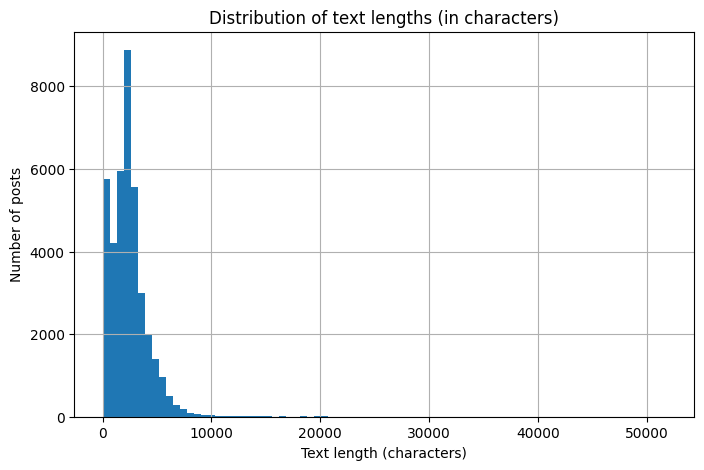

In [10]:
raw_df["text_length"] = raw_df["text"].apply(len)

# Plot histogram of distribution
plt.figure(figsize=(8, 5))
plt.hist(raw_df["text_length"], bins=80)
plt.title("Distribution of text lengths (in characters)")
plt.xlabel("Text length (characters)")
plt.ylabel("Number of posts")
plt.grid()
plt.show()

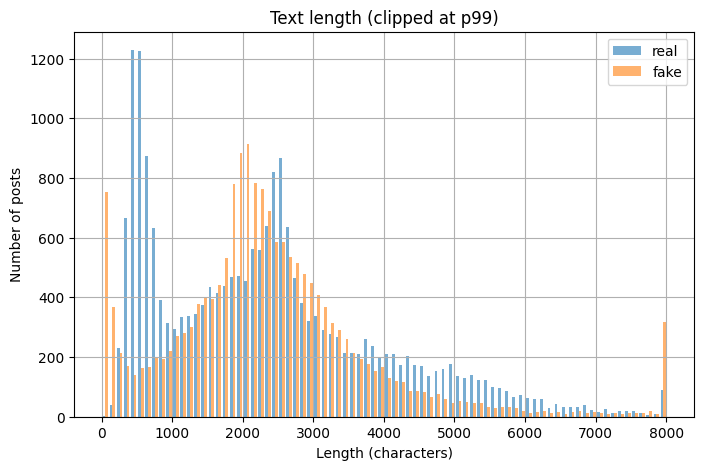

In [11]:
p99 = raw_df["text_length"].quantile(0.99)
real = raw_df.loc[raw_df["is_fake"]==0, "text_length"].clip(upper=p99)
fake = raw_df.loc[raw_df["is_fake"]==1, "text_length"].clip(upper=p99)

bins = 80
plt.figure(figsize=(8,5))
plt.hist([real, fake], bins=bins, alpha=0.6, label=["real","fake"])
plt.title("Text length (clipped at p99)")
plt.xlabel("Length (characters)")
plt.ylabel("Number of posts")
plt.grid()
plt.legend()
plt.show()


In [12]:
most_common_length = raw_df["text_length"].mode()[0]
mean_length = raw_df["text_length"].mean()
median_length = raw_df["text_length"].median()

most_common_length, mean_length, median_length

(np.int64(1), np.float64(2428.340358056266), 2211.0)

In [13]:
# гарантуємо довжини
raw_df["text_len_chars"] = raw_df["text"].astype(str).str.len()
raw_df["text_len_words"] = raw_df["text"].astype(str).str.split().apply(len)

real = raw_df["is_fake"].eq(0)
fake = raw_df["is_fake"].eq(1)

def collect_stats(df):
    return {
        "text_length_mean":  df["text_length"].mean(),
        "text_length_median":df["text_length"].median(),
        "text_length_mode":  df["text_length"].mode().iat[0],
        "len_chars_mean":    df["text_len_chars"].mean(),
        "len_chars_median":  df["text_len_chars"].median(),
        "len_words_mean":    df["text_len_words"].mean(),
        "len_words_median":  df["text_len_words"].median(),
    }

summary = pd.DataFrame({
    "overall": collect_stats(raw_df),
    "real":    collect_stats(raw_df[real]),
    "fake":    collect_stats(raw_df[fake]),
}).T.round(1)

summary


,text_length_mean,text_length_median,text_length_mode,len_chars_mean,len_chars_median,len_words_mean,len_words_median
overall,2428.3,2211.0,1.0,2428.3,2211.0,398.6,366.0
real,2378.7,2217.0,482.0,2378.7,2217.0,384.9,359.0
fake,2487.1,2205.0,1.0,2487.1,2205.0,414.8,371.0


In [14]:
# Tokens (if not already created)
if "tokens" not in raw_df:
    raw_df["tokens"] = raw_df["text"].fillna("").astype(str).str.lower().apply(
        lambda s: re.findall(r"\b\w+\b", s)
    )

STOP = set(ENGLISH_STOP_WORDS)

def clean_tokens(tokens, min_len=3):
    """
    Remove stopwords and short tokens.

    Parameters
    ----------
    tokens : list of str
        List of tokens (words) to be cleaned.
    min_len : int, optional, default=3
        Minimum token length to keep.

    Returns
    -------
    list of str
        Cleaned tokens without stopwords and too short words.
    """
    return [w for w in tokens if len(w) >= min_len and w not in STOP]


def token_freq(tokens_series, min_count=3):
    """
    Calculate normalized token frequencies from a series of token lists.

    Parameters
    ----------
    tokens_series : pandas.Series
        Series of lists with tokens for each text.
    min_count : int, optional, default=3
        Minimum number of occurrences for a token to be included.

    Returns
    -------
    dict
        Dictionary mapping tokens to their normalized frequency.
    """
    c = Counter()
    for toks in tokens_series:
        c.update(clean_tokens(toks))
    c = Counter({w: cnt for w, cnt in c.items() if cnt >= min_count})
    tot = sum(c.values()) or 1
    return {w: cnt / tot for w, cnt in c.items()}


real = raw_df["is_fake"].eq(0)
fake = raw_df["is_fake"].eq(1)
f_real = token_freq(raw_df.loc[real, "tokens"])
f_fake = token_freq(raw_df.loc[fake, "tokens"])

# Top words and comparison table
top_k = 20
print("TOP-20 REAL:", sorted(f_real.items(), key=lambda x: x[1], reverse=True)[:top_k])
print("TOP-20 FAKE:", sorted(f_fake.items(), key=lambda x: x[1], reverse=True)[:top_k])

vocab = sorted(set(f_real) | set(f_fake))
tbl = pd.DataFrame({"word": vocab})
tbl["freq_real"] = tbl["word"].map(f_real).fillna(0.0)
tbl["freq_fake"] = tbl["word"].map(f_fake).fillna(0.0)

display(tbl.sort_values("freq_real", ascending=False).head(top_k))
display(tbl.sort_values("freq_fake", ascending=False).head(top_k))


TOP-20 REAL: [('said', 0.021960303503870567), ('trump', 0.012139436512857073), ('reuters', 0.006433587091253635), ('president', 0.00625400962804569), ('state', 0.0046690140434065665), ('government', 0.004163952428134222), ('new', 0.003757658417626246), ('house', 0.003700418101228714), ('states', 0.0036849295450270287), ('republican', 0.003622975320220288), ('united', 0.0034490096527375913), ('people', 0.003385259653298771), ('year', 0.003276166344399944), ('told', 0.0031578696905117105), ('washington', 0.002892543988621972), ('party', 0.0028261003272350323), ('election', 0.002732046630879871), ('campaign', 0.002365259662277644), ('donald', 0.002328221810491005), ('security', 0.0022458406492443603)]
TOP-20 FAKE: [('trump', 0.018141381058795224), ('said', 0.006611641594350449), ('people', 0.00564869838801602), ('president', 0.00554078693296194), ('just', 0.0044611394863468025), ('donald', 0.004072924696189287), ('like', 0.003829124742178218), ('clinton', 0.0036047754948806006), ('obama',

,word,freq_real,freq_fake
40060,said,0.021960,0.006612
47088,trump,0.012139,0.018141
38900,reuters,0.006434,0.000080
35937,president,0.006254,0.005541
43716,state,0.004669,0.002530
20020,government,0.004164,0.001671
31750,new,0.003758,0.002771
22301,house,0.003700,0.002246
43730,states,0.003685,0.002022
38557,republican,0.003623,0.002126


,word,freq_real,freq_fake
47088,trump,0.012139,0.018141
40060,said,0.021960,0.006612
34435,people,0.003385,0.005649
35937,president,0.006254,0.005541
25195,just,0.000991,0.004461
14591,donald,0.002328,0.004073
27339,like,0.001041,0.003829
9940,clinton,0.002125,0.003605
32505,obama,0.002095,0.003565
46225,time,0.001650,0.002853


In [15]:
# Unique Words + TTR (Type–Token Ratio) — an indicator of a text’s lexical diversity

df_lex = raw_df[["tokens","is_fake"]].copy()

df_lex["len_words"]  = df_lex["tokens"].apply(len)
df_lex["uniq_words"] = df_lex["tokens"].apply(lambda t: len(set(t)))
df_lex["ttr"]        = (df_lex["uniq_words"] / df_lex["len_words"].replace(0, np.nan)).fillna(0.0)

real = df_lex["is_fake"].eq(0)
fake = df_lex["is_fake"].eq(1)

lex_stats = pd.DataFrame({
    "len_words_mean":   [df_lex.loc[real,"len_words"].mean(),   df_lex.loc[fake,"len_words"].mean()],
    "len_words_median": [df_lex.loc[real,"len_words"].median(), df_lex.loc[fake,"len_words"].median()],
    "uniq_words_mean":  [df_lex.loc[real,"uniq_words"].mean(),  df_lex.loc[fake,"uniq_words"].mean()],
    "uniq_words_median":[df_lex.loc[real,"uniq_words"].median(),df_lex.loc[fake,"uniq_words"].median()],
    "ttr_mean":         [df_lex.loc[real,"ttr"].mean(),         df_lex.loc[fake,"ttr"].mean()],
    "ttr_median":       [df_lex.loc[real,"ttr"].median(),       df_lex.loc[fake,"ttr"].median()],
}, index=["real","fake"]).round(2)

display(lex_stats)


,len_words_mean,len_words_median,uniq_words_mean,uniq_words_median,ttr_mean,ttr_median
real,393.04,366.0,206.06,201.0,0.59,0.56
fake,427.78,383.0,219.05,211.0,0.56,0.55


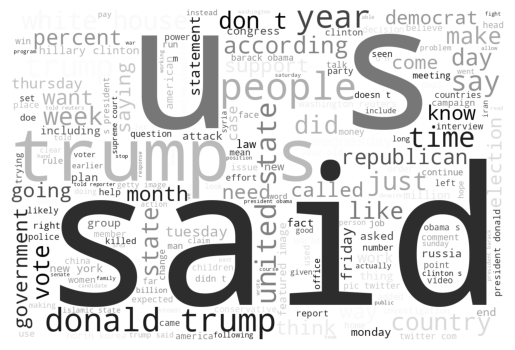

In [16]:
text_all = " ".join(raw_df["text"].fillna("").astype(str).str.lower())

def create_wordcloud(text: str, stopwords_list: set) -> None:
    """
    Generate and display a word cloud from the given text.

    Parameters
    ----------
    text : str
        Input text from which to generate the word cloud.
    stopwords_list : set
        Set of words to be excluded from the word cloud.

    Returns
    -------
    None
        Displays the word cloud using matplotlib.
    """
    wc = WordCloud(
        background_color='white',
        colormap='binary',
        stopwords=stopwords_list,
        width=1200,
        height=800
    ).generate(text)

    plt.axis("off")
    plt.imshow(wc)

create_wordcloud(text_all, STOP)


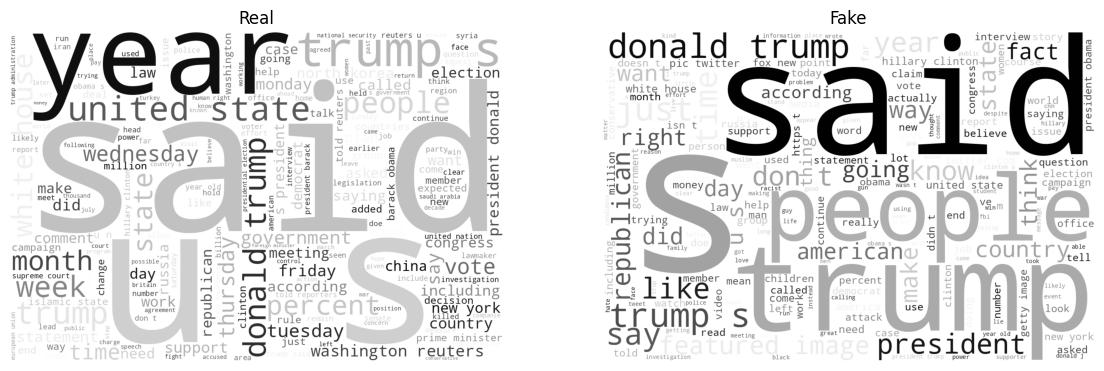

In [17]:
text_real = " ".join(raw_df.loc[real, "text"].fillna("").astype(str).str.lower())
text_fake = " ".join(raw_df.loc[fake, "text"].fillna("").astype(str).str.lower())

plt.figure(figsize=(14,6))
plt.subplot(1,2,1); create_wordcloud(text_real, STOP); plt.title("Real")
plt.subplot(1,2,2); create_wordcloud(text_fake, STOP); plt.title("Fake")
plt.show()

## Conclusions

**Class balance:** 54.2% fake (1) vs 45.8% real (0) — classes are nearly balanced, with a slight skew toward fake.  

**Text length:**  
- Characters — mean: real ≈ 2378, fake ≈ 2487  
- Characters — median: real ≈ 2217, fake ≈ 2205  
- Words — mean: real ≈ 393, fake ≈ 428  
- Words — median: real ≈ 366, fake ≈ 383  

➡️ Fake texts are slightly longer on average by word count; by median, the difference is minimal.  

**Lexical diversity:**  
- Unique words — mean: real ≈ 206, fake ≈ 219  
- Unique words — median: real ≈ 201, fake ≈ 211  
- TTR — mean: real ≈ 0.59, fake ≈ 0.56  
- TTR — median: real ≈ 0.56, fake ≈ 0.55  

➡️ Fake texts contain slightly more unique words (because they are longer), but TTR is almost identical, meaning relative lexical diversity is similar.  

**Vocabulary:**  
- REAL (0) — top words: *said, trump, reuters, president, state*  
- FAKE (1) — top words: *trump, said, president, people, just*  

➡️ *said, reuters, president* are common news markers; *reuters* in real is a news source itself. Fake texts show more everyday/emotional words (*people, just*), reflecting stylistic differences.  

**Data leakage:**  
- In real news, dates are almost always present; in fake news, many are missing.  
- All date-related features (`date`, `date_isna`, `days_since_ref`) must be excluded from modeling.  

**Duplicates:** dataset contains **5580 duplicates** — must be removed before creating splits for models.  

**Length distribution:** fake texts are more “concentrated” in medium lengths; real texts show a wider spread (more very short and very long articles).  

**Anomalies:** some abnormally short texts were found (mode ≈ 1).  
